In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import pandas as pd
import math
import random as rdm
import checkNNGradients as compararGradientes

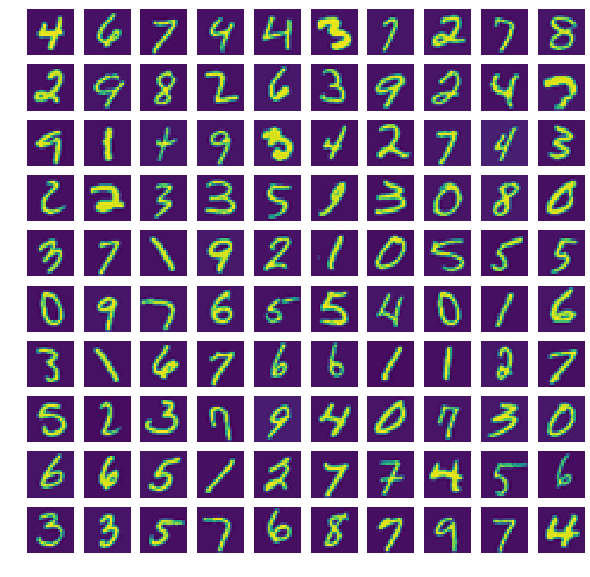

In [2]:
# se pueden consultar las claves con data . keys ( )
weights = loadmat('C:/Users/HAO-H/Documents/Universidad/AA/zPracticas/practica4/ex4weights.mat')
data = loadmat('C:/Users/HAO-H/Documents/Universidad/AA/zPracticas/practica4/ex4data1.mat')
#Theta1 es de dimensión 25 x 401
#Theta2 es de dimensión 10 x 26
theta1, theta2 = weights['Theta1'], weights['Theta2']

X = data['X']
y = data['y']
# visualizing the data
_, axarr = plt.subplots(10,10,figsize=(10,10))
for i in range(10):
    for j in range(10):
       axarr[i,j].imshow(X[np.random.randint(X.shape[0])].\
reshape((20,20), order = 'F'))          
       axarr[i,j].axis('off')
        
        
        
nn_params = np.hstack((theta1.ravel(order='F'), theta2.ravel(order='F')))    #unroll parameters
# neural network hyperparameters
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10
lmbda = 1

In [3]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [23]:
def nnCostFunc(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda):
    theta1 = np.reshape(nn_params[:hidden_layer_size*(input_layer_size+1)], (hidden_layer_size, input_layer_size+1), 'F')
    theta2 = np.reshape(nn_params[hidden_layer_size*(input_layer_size+1):], (num_labels, hidden_layer_size+1), 'F')

    m = len(y)
    ones = np.ones((m,1))
    a1 = np.hstack((ones, X))
    a2 = sigmoid(a1 @ theta1.T)
    a2 = np.hstack((ones, a2))
    h = sigmoid(a2 @ theta2.T)
    
    yy = listToArray(y)
    y_d = pd.get_dummies(yy.flatten())
    
    temp1 = np.multiply(y_d, np.log(h))
    temp2 = np.multiply(1-y_d, np.log(1-h))
    temp3 = np.sum(temp1 + temp2)
    
    sum1 = np.sum(np.sum(np.power(theta1[:,1:],2), axis = 1))
    sum2 = np.sum(np.sum(np.power(theta2[:,1:],2), axis = 1))
    
    return np.sum(temp3 / (-m)) + (sum1 + sum2) * lmbda / (2*m)

In [5]:
nnCostFunc(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda)

0.38376985909092354

In [6]:
def sigmoidGrad(z):
    return np.multiply(sigmoid(z), 1-sigmoid(z))

In [7]:
def randInitializeWeights(L_in, L_out):
    epsilon = 0.12
    return np.random.rand(L_out, L_in+1) * 2 * epsilon - epsilon

initial_theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# unrolling parameters into a single column vector
nn_initial_params = np.hstack((initial_theta1.ravel(order='F'), initial_theta2.ravel(order='F')))

In [27]:
def nnGrad(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda):
    
    initial_theta1 = np.reshape(nn_params[:hidden_layer_size*(input_layer_size+1)], (hidden_layer_size, input_layer_size+1), 'F')
    initial_theta2 = np.reshape(nn_params[hidden_layer_size*(input_layer_size+1):], (num_labels, hidden_layer_size+1), 'F')
    yy = listToArray(y)
    y_d = pd.get_dummies(yy.flatten())
    delta1 = np.zeros(initial_theta1.shape)
    delta2 = np.zeros(initial_theta2.shape)
    m = len(y)
    
    for i in range(X.shape[0]):
        ones = np.ones(1)
        a1 = np.hstack((ones, X[i]))
        z2 = a1 @ initial_theta1.T
        a2 = np.hstack((ones, sigmoid(z2)))
        z3 = a2 @ initial_theta2.T
        a3 = sigmoid(z3)

        d3 = a3 - y_d.iloc[i,:][np.newaxis,:]
        z2 = np.hstack((ones, z2))
        d2 = np.multiply(initial_theta2.T @ d3.T, sigmoidGrad(z2).T[:,np.newaxis])
        delta1 = delta1 + d2[1:,:] @ a1[np.newaxis,:]
        delta2 = delta2 + d3.T @ a2[np.newaxis,:]
        
    delta1 /= m
    delta2 /= m
    #print(delta1.shape, delta2.shape)
    delta1[:,1:] = delta1[:,1:] + initial_theta1[:,1:] * lmbda / m
    delta2[:,1:] = delta2[:,1:] + initial_theta2[:,1:] * lmbda / m
        
    return np.hstack((delta1.ravel(order='F'), delta2.ravel(order='F')))

In [10]:
nn_backprop_Params = nnGrad(nn_initial_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda)

In [11]:
def checkGradient(nn_initial_params,nn_backprop_Params,input_layer_size, hidden_layer_size, num_labels,myX,myy,mylambda=0.):
    myeps = 0.0001
    flattened = nn_initial_params
    flattenedDs = nn_backprop_Params
    n_elems = len(flattened) 
    #Pick ten random elements, compute numerical gradient, compare to respective D's
    for i in range(10):
        x = int(np.random.rand()*n_elems)
        epsvec = np.zeros((n_elems,1))
        epsvec[x] = myeps

        cost_high = nnCostFunc(flattened + epsvec.flatten(),input_layer_size, hidden_layer_size, num_labels,myX,myy,mylambda)
        cost_low  = nnCostFunc(flattened - epsvec.flatten(),input_layer_size, hidden_layer_size, num_labels,myX,myy,mylambda)
        mygrad = (cost_high - cost_low) / float(2*myeps)
        print("Element: {0}. Numerical Gradient = {1:.9f}. BackProp Gradient = {2:.9f}.".format(x,mygrad,flattenedDs[x]))

In [12]:
checkGradient(nn_initial_params,nn_backprop_Params,input_layer_size, hidden_layer_size, num_labels,X,y,lmbda)

Element: 9202. Numerical Gradient = -0.000023041. BackProp Gradient = -0.000023041.
Element: 6319. Numerical Gradient = -0.006884428. BackProp Gradient = -0.006884428.
Element: 8059. Numerical Gradient = 0.000004555. BackProp Gradient = 0.000004555.
Element: 3703. Numerical Gradient = 0.013371950. BackProp Gradient = 0.013371950.
Element: 4422. Numerical Gradient = -0.003976964. BackProp Gradient = -0.003976964.
Element: 7395. Numerical Gradient = 0.005710858. BackProp Gradient = 0.005710858.
Element: 4084. Numerical Gradient = -0.000628105. BackProp Gradient = -0.000628105.
Element: 2889. Numerical Gradient = -0.005217715. BackProp Gradient = -0.005217715.
Element: 1831. Numerical Gradient = 0.000404360. BackProp Gradient = 0.000404360.
Element: 7569. Numerical Gradient = -0.000050448. BackProp Gradient = -0.000050448.


In [21]:
def backprop(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda):
    return nnCostFunc(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda), nnGrad(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda)

In [28]:
compararGradientes.checkNNGradients(backprop, 0)

array([-1.81224757e-11,  4.38346373e-11, -3.52901527e-11,  5.89976540e-11,
       -1.33034347e-11,  4.69266986e-13, -1.84145060e-12,  6.88095414e-13,
       -7.24170723e-13, -8.71558034e-13,  1.16675176e-11,  2.70479819e-12,
       -1.04108180e-11,  5.30368804e-12, -2.21182794e-12,  3.83355847e-12,
        3.50152476e-11, -4.49779797e-11,  3.08327947e-11, -1.74048415e-11,
        1.00843639e-10, -6.13002704e-12, -1.11125331e-10,  1.31268885e-11,
       -3.56620289e-12, -1.68873387e-11,  4.17690604e-11,  6.26252522e-12,
       -3.92778726e-11,  4.58008631e-11,  8.16834100e-12, -4.20267987e-11,
        1.61124863e-11, -1.05082609e-12, -1.74083803e-11,  1.20588262e-11,
       -5.59693958e-12, -1.69422150e-11])

In [25]:
def listToArray(y):
    if type(y) == list:
        y = np.array(y).reshape(-1, 1)
        
    return y